<a href="https://colab.research.google.com/github/jhhan0/self-study-ml/blob/main/notes/celeba-cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CelebA Dataset Classifiction using the Convolutional Neural Network

In [1]:
!pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.9/634.9 KB 33.3 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_cv
import numpy as np
import matplotlib.pyplot as plt

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


Download CelebA Dataset using `tfds.load()`.

In [3]:
tfds.disable_progress_bar()
celeba, celeba_info = tfds.load('celeb_a', with_info=True)

Dataset celeb_a downloaded and prepared to /root/tensorflow_datasets/celeb_a/2.0.1. Subsequent calls will reuse this data.


Split CelebA Dataset into `train`, `validation`, and `test` datasets.

In [4]:
celeba_info

tfds.core.DatasetInfo(
    name='celeb_a',
    full_name='celeb_a/2.0.1',
    description="""
    CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset
    with more than 200K celebrity images, each with 40 attribute annotations. The
    images in this dataset cover large pose variations and background clutter.
    CelebA has large diversities, large quantities, and rich annotations,
    including - 10,177 number of identities, - 202,599 number of face images, and -
    5 landmark locations, 40 binary attributes annotations per image.
    
    The dataset can be employed as the training and test sets for the following
    computer vision tasks: face attribute recognition, face detection, and landmark
    (or facial part) localization.
    
    Note: CelebA dataset may contain potential bias. The fairness indicators
    [example](https://www.tensorflow.org/responsible_ai/fairness_indicators/tutorials/Fairness_Indicators_TFCO_CelebA_Case_Study)
    goes into det

In [6]:
tf.random.set_seed(1)
BATCH_SIZE = 64
IMAGE_SIZE = (64, 64)
BUFFER_SIZE = 80000
AUTOTUNE = tf.data.AUTOTUNE

In [11]:
def preprocess_ds(ds):
  image, label = ds['image'], ds['attributes']['Eyeglasses']
  image = tf.image.resize(image, size=IMAGE_SIZE)
  image = tf.cast(image, tf.float32) / 255.0
  label = tf.cast(label, tf.uint8)
  return {"images": image, "labels": label}

def prepare_ds(dataset, split):
    if split == "train":
        return (
            dataset.shuffle(BATCH_SIZE)
            .map(preprocess_ds, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
        )
    if split == "test":
        return dataset.map(preprocess_ds, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

def load_ds(split="train"):
  ds = celeba[split]
  return prepare_ds(ds, split)

Apply some **data augmentation** methods like horizontal/vertical rotation, bounding-box cropping, and adjusting brightness.

- Using `keras_cv.layers.RandomAugmentationPipeline` class and 'keras_cv.layers.RandAugment()` layers. Find out more [here](https://keras.io/api/keras_cv/layers/augmentation/random_augmentation_pipeline/#randomaugmentationpipeline-class).
- Using a custom `tf.image` augmentation method.

In [9]:
layers = keras_cv.layers.RandAugment.get_standard_policy(value_range=(0, 1), magnitude=0.5, magnitude_stddev=0.15)
layers = layers[:4]
pipeline = keras_cv.layers.RandomAugmentationPipeline(layers=layers, augmentations_per_image=3)

def apply_augment_pipeline(inputs):
  inputs["images"] = pipeline(inputs["images"])
  return inputs

In [ ]:
# def augment(inputs, size=(64, 64), mode='train'):
#   image, label = inputs['image'], inputs['attributes']['Eyeglasses']
#   if mode == 'train':
#     image = tf.image.resize(image, size=size)
#     image = tf.image.random_brightness(image, max_delta=0.3)
#     image = tf.image.random_flip_up_down(image)
#     return tf.cast(image, tf.float32) / 255.0, tf.cast(label, tf.uint8)
#   else:
#     image = tf.image.resize(image, size=size)
#     return tf.cast(image, tf.float32) / 255.0, tf.cast(label, tf.uint8)

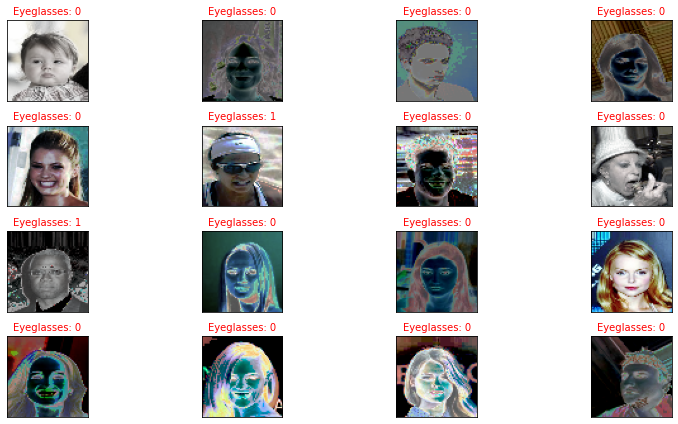

In [18]:
train_ds = load_ds().map(apply_augment_pipeline, num_parallel_calls=AUTOTUNE)
sample_batch = train_ds.take(16)

fig = plt.figure(figsize=(12, 6))
for i, sample in enumerate(sample_batch):
  ax = fig.add_subplot(4, 4, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(sample["images"][0].numpy().astype('float32'))
  ax.set_title('Eyeglasses: {}'.format(sample["labels"][0]), size=10, color='red')

plt.tight_layout()
plt.show()

Create CNN model using `tf.keras.Sequential`.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
])

Add `tf.keras.layers.GlobalAveragePooling2D()` and `tf.keras.layers.Dense()` layers at the end for classification.

In [ ]:
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1, activation=None))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

Configure the compile setting and train the CNN model.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_ds, epochs=1, validation_data=val_ds)

2544/2544 [==============================] - 121s 47ms/step - loss: 0.1474 - accuracy: 0.9534 - val_loss: 0.0808 - val_accuracy: 0.9710


Save the model using `model.save()`.

In [ ]:
# model.save('celeba-cnn.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [ ]:
test_ds = load_ds(split="test")

In [ ]:
results = model.evaluate(test_ds)
print('Test loss: {:.3f}, Test acc: {:.3f}'.format(*results))

312/312 [==============================] - 11s 34ms/step - loss: 0.0714 - accuracy: 0.9761
Test loss: 0.071, Test acc: 0.976


Display 10 CelebA test dataset images with its correct and predicted labels (in this case, it is *Eyeglasses*)

In [ ]:
samples = test_ds.unbatch().take(10)

In [ ]:
logits = model.predict(samples.batch(1))
probas = np.round(tf.sigmoid(logits).numpy().flatten(), decimals=2)*100
print(probas)

10/10 [==============================] - 1s 10ms/step
[ 0.  4.  0. 68.  0.  3.  0. 99.  1.  1.]


In [ ]:
class_labels = ['Wear Eyeglasses', 'No Eyeglasses']

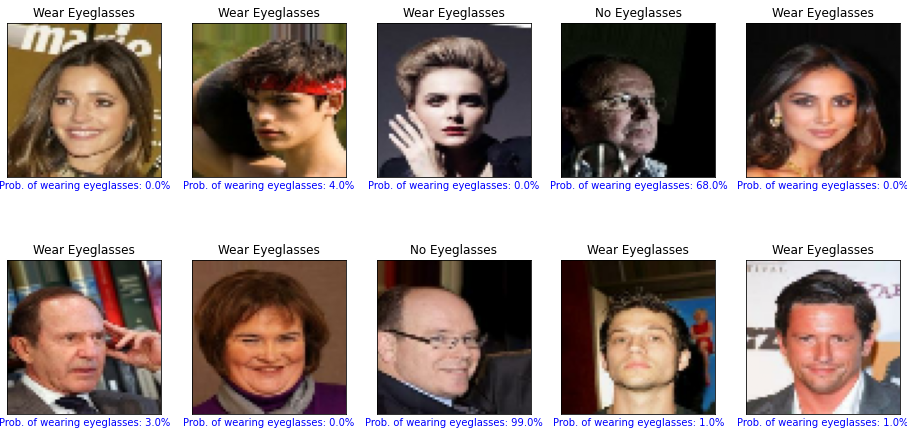

In [ ]:
fig = plt.figure(figsize=(16, 8))
for element in samples.enumerate():
  ax = fig.add_subplot(2, 5, element[0].numpy()+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('Prob. of wearing eyeglasses: {}%'.format(probas[element[0].numpy()]), color='blue')
  ax.set_title('{}'.format(class_labels[element[1][1].numpy()]))
  ax.imshow(element[1][0].numpy())
plt.show()